<a href="https://colab.research.google.com/github/tomasbelak24/deeplearning-vision/blob/main/hw1/baseline_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Basic model (1pt)

The goal is to ideally design the fastest possible model that will reach approx. 70 percent accuracy on Cifar-10 dataset. This model will serve as a baseline for further modifications. Use the Adam optimizer and ReLU activations within the model. The beginning of the model should consist of a few convolutional and pooling layers. There should be a fully connected part at the end.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
from matplotlib import pyplot as plt

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


torch.Size([1, 3, 32, 32])


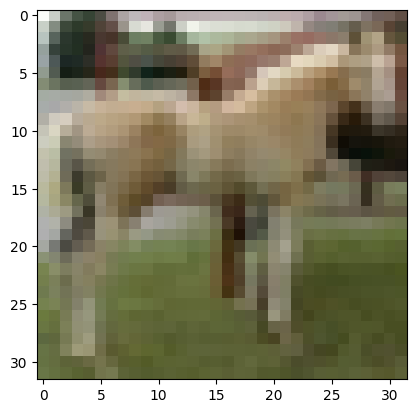

tensor([7])
horse
torch.Size([1, 3, 32, 32])


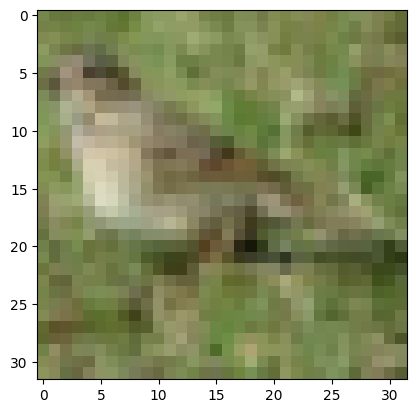

tensor([2])
bird
torch.Size([1, 3, 32, 32])


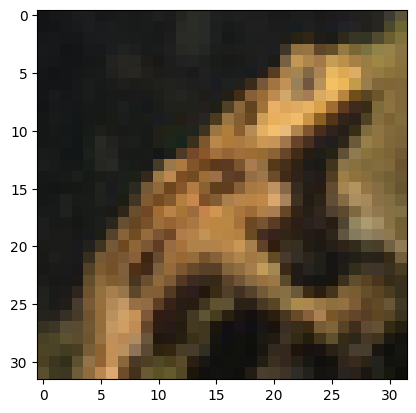

tensor([6])
frog
torch.Size([1, 3, 32, 32])


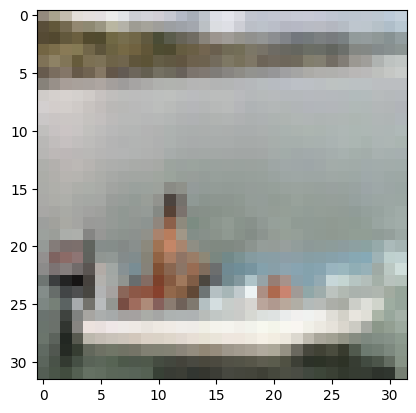

tensor([8])
ship
torch.Size([1, 3, 32, 32])


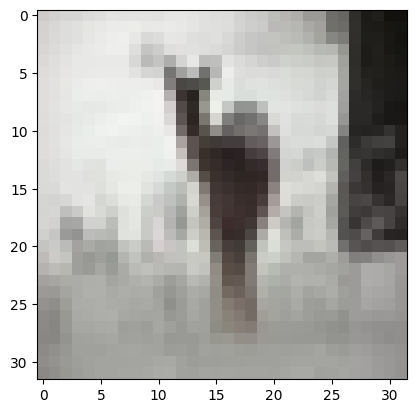

tensor([4])
deer
torch.Size([1, 3, 32, 32])


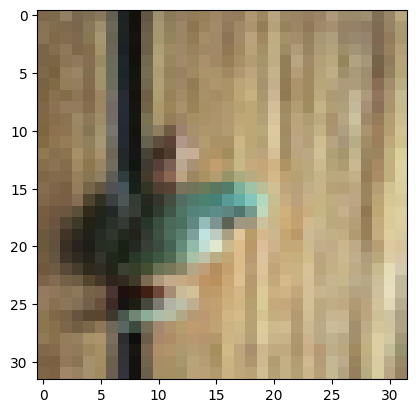

tensor([6])
frog
torch.Size([1, 3, 32, 32])


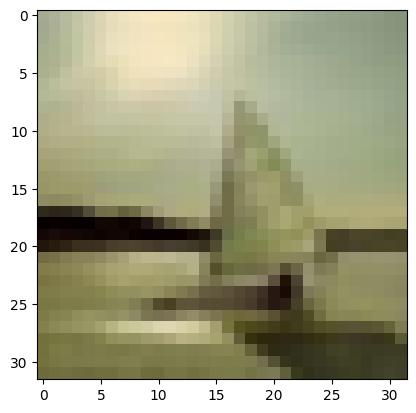

tensor([8])
ship
torch.Size([1, 3, 32, 32])


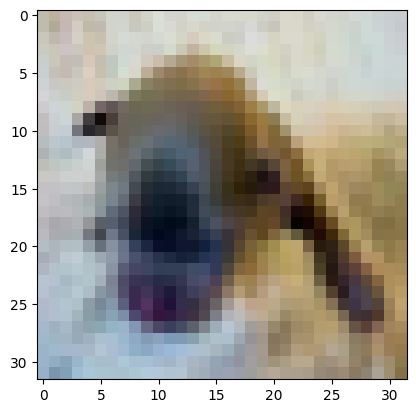

tensor([5])
dog
torch.Size([1, 3, 32, 32])


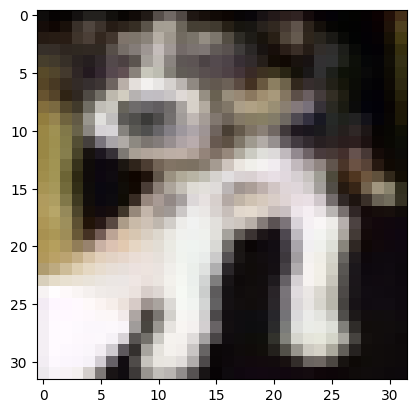

tensor([5])
dog
torch.Size([1, 3, 32, 32])


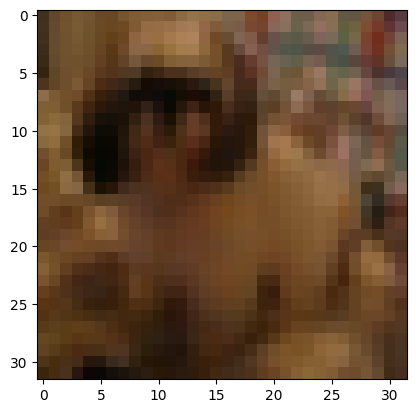

tensor([5])
dog
torch.Size([1, 3, 32, 32])


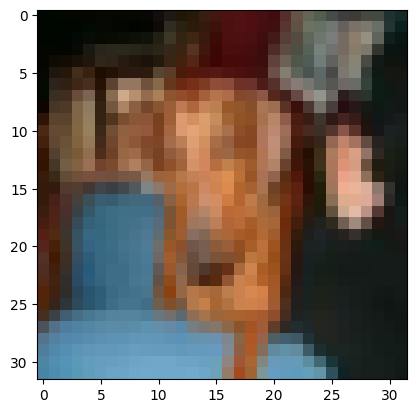

tensor([5])
dog


In [2]:
# @title Loading CIFAR10 dataset

#reused code from the 5th lab

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

transform = transforms.ToTensor()

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# for reproducibility
trainset, valset = torch.utils.data.random_split(dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

previewloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

for i, sample in enumerate(previewloader):
  if i > 10:
    break
  x, y = sample
  print(x.shape)
  img = np.moveaxis(x.numpy()[0], 0, -1)
  plt.imshow(img)
  plt.show()
  print(y)
  print(classes[y.item()])

In [6]:
from torch.nn import Sequential, Linear, ReLU, Softmax, Conv2d, MaxPool2d, Flatten, AdaptiveAvgPool2d

def build_model():
  # We have three channels on input in shape N x 3 x 32 x 32
  model = Sequential(
      Conv2d(3, 32, 3), MaxPool2d(2), ReLU(),
      Conv2d(32, 64, 3), MaxPool2d(2), ReLU(),
      Conv2d(64, 128, 3), MaxPool2d(2), ReLU(),
      AdaptiveAvgPool2d(1),Flatten(),
      Linear(128, 64), ReLU(),
      Linear(64, 32), ReLU(),
      Linear(32, 10))

  model_inference = Sequential(model, Softmax(dim=1))
  return model, model_inference

model, model_inference = build_model()

out = model_inference(torch.from_numpy(np.zeros([1, 3, 32, 32], dtype=np.float32)))
print(out.size())
print(out)
print(classes[out.argmax().item()])

torch.Size([1, 10])
tensor([[0.0978, 0.1109, 0.1139, 0.0938, 0.1073, 0.1032, 0.0992, 0.0893, 0.0927,
         0.0918]], grad_fn=<SoftmaxBackward0>)
bird


In [7]:
def one_epoch(model, loss, optimizer, dataloader_train, dataloader_val, verbose=True):
  train_losses = []
  val_losses = []

  model.train()
  for i, batch in enumerate(dataloader_train):
    x, y = batch[0].to(device), batch[1].to(device)
    optimizer.zero_grad()

    out = model(x)
    loss = ce_loss(out, y)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    if i % 100 == 0 and verbose:
      print("Training loss at step {}: {}".format(i, loss.item()))

  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for i, batch in enumerate(dataloader_val):
      x, y = batch[0].to(device), batch[1].to(device)

      out = model(x)
      loss = ce_loss(out, y)
      acc = torch.sum(torch.argmax(out, dim=-1) == y)
      correct += acc.item()
      total += len(batch[1])
      val_losses.append(loss.item())

  val_acc = correct / total

  return np.mean(train_losses), np.mean(val_losses), val_acc

Using device:  cuda:0
Training loss at step 0: 2.31158709526062
Training loss at step 100: 2.03782320022583
Training loss at step 200: 2.013432502746582
Training loss at step 300: 1.9299209117889404
Training loss at step 400: 1.8859248161315918
Training loss at step 500: 1.8050897121429443
Training loss at step 600: 1.825762152671814
Training loss at step 700: 1.7533767223358154
Training loss at step 800: 1.7885485887527466
Training loss at step 900: 1.7446612119674683
Training loss at step 1000: 1.777255892753601
Training loss at step 1100: 1.736431360244751
Training loss at step 1200: 1.5703330039978027
Training loss at step 1300: 1.622395396232605
Training loss at step 1400: 1.655982494354248
Val loss at epoch 0: 1.7673656128014728
Val acc at epoch 0: 0.3328
Training loss at step 0: 1.647160530090332
Training loss at step 100: 1.7799615859985352
Training loss at step 200: 1.553434133529663
Training loss at step 300: 1.4415514469146729
Training loss at step 400: 1.4506642818450928
Tr

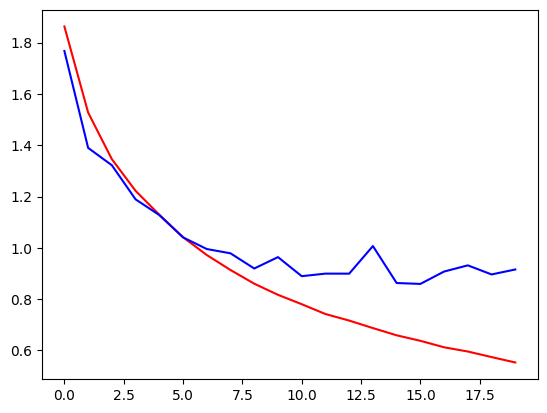

In [9]:
batch_size = 32

dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

ce_loss = torch.nn.CrossEntropyLoss().to(device)

model, model_inference = build_model()

model.to(device)
model_inference.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epoch_train_losses = []
epoch_val_losses = []
epoch_val_accs = []

for e in range(20):
  train_loss, val_loss, val_acc = one_epoch(model, ce_loss, optimizer, dataloader_train, dataloader_val)

  print("Val loss at epoch {}: {}".format(e, val_loss))
  print("Val acc at epoch {}: {}".format(e, val_acc))

  torch.save(model.state_dict(), "{:03d}.pth".format(e))
  epoch_train_losses.append(train_loss)
  epoch_val_losses.append(val_loss)
  epoch_val_accs.append(val_acc)

plt.plot(epoch_train_losses, c='r')
plt.plot(epoch_val_losses, c='b')
plt.show()

In [10]:
# @title Dumping losses and val accuracy into json
import json

baseline_results = {
    'train_losses': epoch_train_losses,
    'val_losses': epoch_val_losses,
    'val_accuracies': epoch_val_accs
}

with open('baseline_results.json', 'w') as f:
    json.dump(baseline_results, f)

print("Baseline results saved to baseline_results.json")

Baseline results saved to baseline_results.json
